# Submitted By : <font color = blue> RAJESH SUGURU </font>

# Capstone Project: <font color = blue> Time Series Forecasting </font>

## Ref : https://learn.upgrad.com/v/course/498/session/116755/segment/645171


## Problem Statement

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality.

 

With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column. Note that some stores in the dataset were temporarily closed for refurbishment.


## Data definition


Most of the fields are self-explanatory. The following are descriptions for important variables.

> - Id - an Id that represents a (Store, Date) duple within the test set
> - Store - a unique Id for each store
> - Sales - the turnover for any given day (this is what you are predicting)
> - Customers - the number of customers on a given day
> - Open - an indicator for whether the store was open: 0 = closed, 1 = open
> - StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
> - SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
> - StoreType - differentiates between 4 different store models: a, b, c, d
> - Assortment - describes an assortment level: a = basic, b = extra, c = extended
> - CompetitionDistance - distance in meters to the nearest competitor store
> - CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
> - Promo - indicates whether a store is running a promo on that day
> - Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
> - Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
> - PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## Recommendations to explore the data and to build  the model

> - Find outliers at 99th percentile and remove them.
> - Standardise the sales and number of customers variables before modelling.
> - Test the data for non-stationarity using ADF test for sales
> - Determine if the data is stationary
> - If stationary then specify Vector Autoregression Model in Levels
> - If non-stationary then specify the model in differences
> - Make sales, promo2 and any other variables you think as dependent variables.
> - Check for cointegration using Johansen test. 
> - Find out Impulse Response Function to answer questions Q3- to Q7. 
> - Predict sales for the next 6 weeks.

## Model Building Approach 

> - Import required useful libraries to perform time series forecasting
> - User Defined Helper Functions (UDHF) to explore the data and build the model
> - Example stationary timeseries VAR and VARMAX model
> - Two non-stationary timeseries VAR model
> - One non-stationary timeseries VAR model
> - Connect all the pipes and build pipeline for all stores

## Fit the pipes and build the Pipeline
### Define udhf_rossmann_prediction Pipeline as Single User Defined Helper Function to re-use for all the stores 
- Select Store
- Reverse Order
- Remove Outliers in sales, 99 Percentile
- Reset Index
- Extract Months
- Create dummies for Weekdays and Months
- Check Stationary
- Drop Not Useful Features
- Decompose the TimeSeries
- Find the frequency with the Lowest Error Sales
- Save the Trend and Seasonality as features
- Find the frequency with the Lowest Error Customers
- Prepare Train Test Data
- Define Endogenouse and Exogenous Train variables
- Difference the TimeSeries if Sales or Customers TimeSeries is not stationary
- Define Endogenouse and Exogenous Test Variables
- Fit the model
- Forecast the model
- If the series is not stationay do difference when necessary
- Benchmark the model
- Plot and save the output as store_{store_id}.png and store_{store_id}.csv

# Import Libraries

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

# statmodels for time series 
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VECM
from statsmodels.tsa.vector_ar.vecm import coint_johansen

## User Defined Helper Functions(udhf) Starts here

### User Defined Helper Function to Remove outliers that exceeds certain percentile

In [96]:
def udhf_remove_outliers(df, column, percentile = 0.99):
    thresh = df[column].quantile(percentile)
    return df[df[column] <= thresh]

### User Defined Helper Function to test if stationary

In [97]:
def udhf_test_stationary(df, column):
    result = adfuller(df[column], autolag = 'AIC')
    return result[0] < result[4]['5%']

In [98]:
def udhf_granger_test(df, X, Y, lags = 1):
    result = grangercausalitytests(df[[Y, X]], lags)
    return result.get(1)[0].get('ssr_ftest')[1]

## Note: If below User Defined Helper Function udhf_decompose fails due to the version library that you are using try to define the function with the below code and try again
def udhf_decompose(df, column, add_mult = 'additive', freq = 300):
    res = seasonal_decompose(df[column], model = add_mult, period = freq, extrapolate_trend='freq')
    return res
### User Defined Helper Function to Seasonal Decompose, Additive/Multiplicative


In [99]:
def udhf_decompose(df, column, add_mult = 'additive', freq = 300):
    res = seasonal_decompose(df[column], model = add_mult, freq = freq, extrapolate_trend='freq')
    return res

In [100]:
def udhf_find_season(df, column, fmax = 300):
    residuals = []
    for i in range(2, fmax):
        result = udhf_decompose(df, column, freq = i)
        residuals.append(abs(result.resid.mean()))
    return np.array(residuals).argmin()+2

In [101]:
def return_dummies(df, column, pref = 'day'):
    return pd.get_dummies(df, columns = [column], prefix = pref)

In [102]:
def return_storedata(df, store_id = 1, only_open = 1):
    return df.query(f'Store == {store_id} and Open == {only_open}')

In [103]:
def udhf_standardize_series(df, column):
    mean = df[column].mean()
    stdev = df[column].std()
    temp = (df[column] - mean)/stdev
    return mean, stdev, temp


In [104]:
def udhf_mnstd_standardize_series(series, mean, stdev):
    return stdev*series+mean

In [105]:
def udhf_calculate_mpe(true, predicted):
    MPE=np.mean((true-predicted)/true)
    return MPE

In [106]:
def udhf_calculate_mape(true, predicted):
    MAPE=np.mean(abs((true-predicted)/true))
    return MAPE

In [107]:
def udhf_difference_timeseries(series, dropnan = True):
    if dropnan:
        return series.diff().dropna()
    else:
        return series.diff()

In [108]:
def udhf_difference_original_timeseries(original, diff_series):
    return diff_series.cumsum() + original[-1]

## User Defined Helper Functions(udhf) Ends here

### Read the data from the train.csv

In [109]:
data_df = pd.read_csv('train.csv', encoding="ISO-8859-1", low_memory=False)

## Stationary timeseries VARMAX model Starts Here
### Model developed for store id 8

In [110]:
store_id = 8

In [111]:
# extract the data for "store_id", choose only data on open days
store_df = data_df.query(f'Store == {store_id} and Open == 1')

## Perform sanity checks starts here

In [112]:
store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
7,8,5,2015-07-31,8492,833,1,1,0,1
1122,8,4,2015-07-30,8420,882,1,1,0,1
2237,8,3,2015-07-29,7029,698,1,1,0,1
3352,8,2,2015-07-28,6717,695,1,1,0,1
4467,8,1,2015-07-27,8739,841,1,1,0,1


In [113]:
store_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1009412,8,1,2013-01-07,7416,802,1,1,0,0
1011642,8,6,2013-01-05,2337,312,1,0,0,0
1012757,8,5,2013-01-04,4059,517,1,0,0,1
1013872,8,4,2013-01-03,4842,662,1,0,0,1
1014987,8,3,2013-01-02,5419,698,1,0,0,1


### Reverse the order of data to run from past to present

In [114]:
store_df = store_df.iloc[::-1]

In [115]:
store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1014987,8,3,2013-01-02,5419,698,1,0,0,1
1013872,8,4,2013-01-03,4842,662,1,0,0,1
1012757,8,5,2013-01-04,4059,517,1,0,0,1
1011642,8,6,2013-01-05,2337,312,1,0,0,0
1009412,8,1,2013-01-07,7416,802,1,1,0,0


### Reset the index

In [116]:
store_df = store_df.reset_index(drop=True)

In [117]:
store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,8,3,2013-01-02,5419,698,1,0,0,1
1,8,4,2013-01-03,4842,662,1,0,0,1
2,8,5,2013-01-04,4059,517,1,0,0,1
3,8,6,2013-01-05,2337,312,1,0,0,0
4,8,1,2013-01-07,7416,802,1,1,0,0


### Check for missing values

In [118]:
store_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

### Visual inspection of 
- Sales(customers)

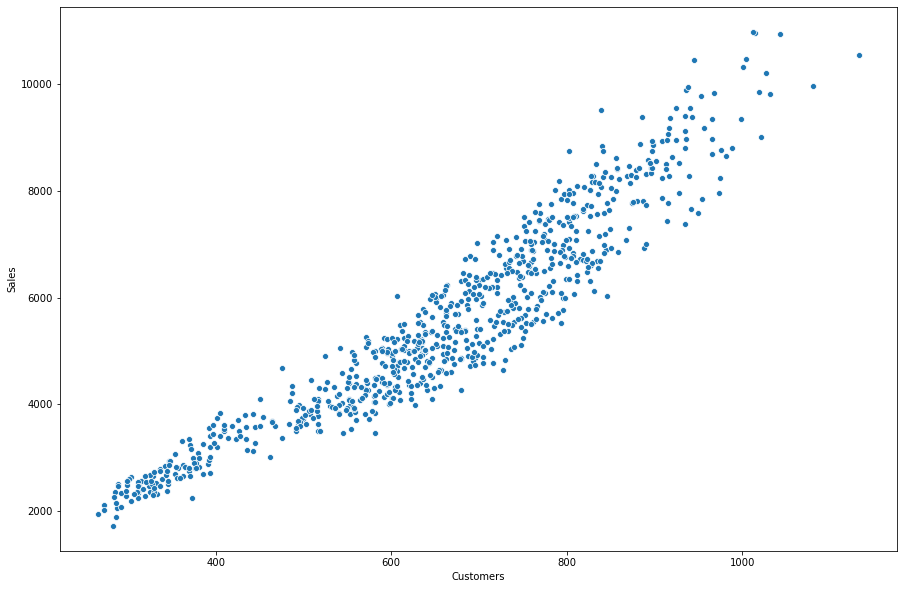

In [119]:
plt.figure(figsize = (15,10))
sns.scatterplot(data = store_df, x = 'Customers', y = 'Sales')

### Visualize and inspect the 
- Sales(customers) and 
- Promo influence

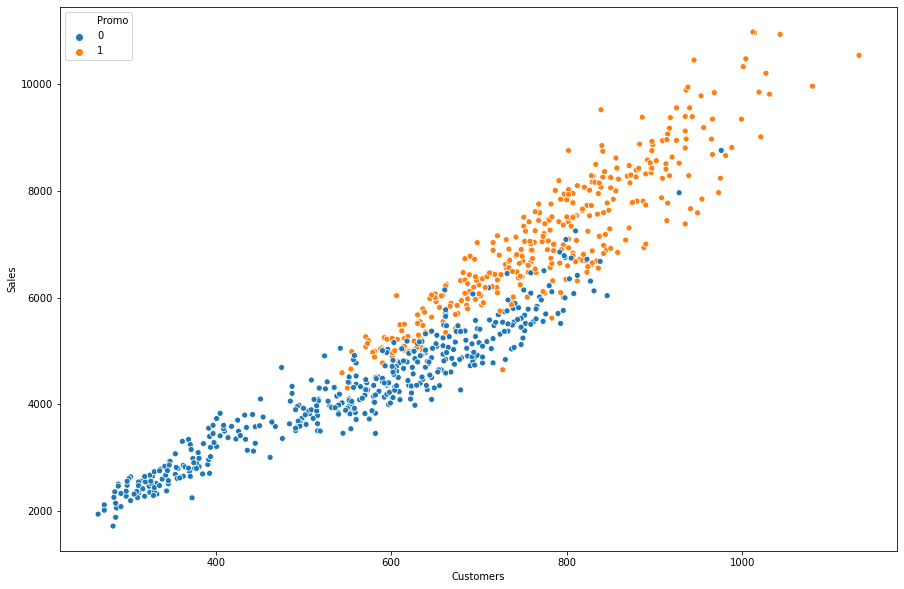

In [120]:
plt.figure(figsize = (15,10))
sns.scatterplot(data = store_df, x = 'Customers', y = 'Sales', hue = 'Promo')

## Inferences:
- Certainly noticed correlation between sales and customers
- When promo is published a slightly higher sales are observed
- Observed More customers per day are attracted when promo is active

### Draw observations for SchoolHoliday Influence

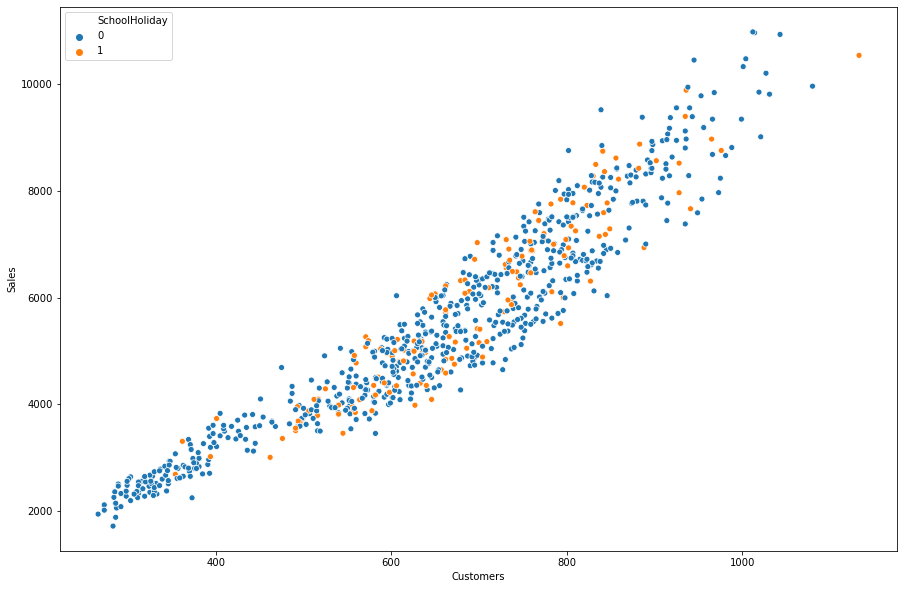

In [121]:
plt.figure(figsize = (15,10))
sns.scatterplot(data = store_df, x = 'Customers', y = 'Sales', hue = 'SchoolHoliday')

## Inferences:
- Observed School Holidays got minimum influence on sales
- Promo got much more influence on sales than the SchoolHolidays

### Covert the month DF to date time format.

In [122]:
store_df['month'] = store_df.Date.apply(lambda str_: datetime.strptime(str_, '%Y-%m-%d').month)

### Check some of month or weekday effects

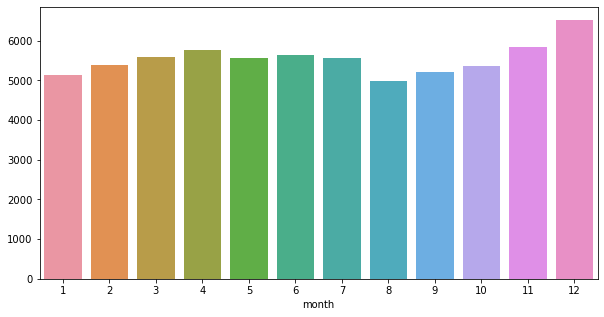

In [123]:
result = store_df.groupby(['month']).mean().Sales
plt.figure(figsize = (10,5))
sns.barplot(x = result.index, y = result.values)

## Inferences :
- Festive season November Easter seems to have a small effect on sales. 
- Festive season December Christmas seems to have bit higher effect on sales

### Check for weekdays

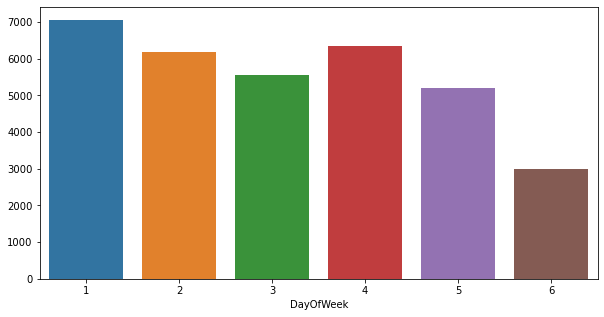

In [124]:
result = store_df.groupby(['DayOfWeek']).mean().Sales
plt.figure(figsize = (10,5))
sns.barplot(x = result.index, y = result.values)

## Inferences:

- When drawn observations on weekdays sales, observed slightly more sales on mondays

### Create dummies for weekdays and months

In [125]:
store_dummies = return_dummies(store_df, 'DayOfWeek', pref = 'day')
store_dummies = return_dummies(store_dummies, 'month', pref = 'month')

In [126]:
store_dummies.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,day_1,day_2,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,8,2013-01-02,5419,698,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,2013-01-03,4842,662,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,2013-01-04,4059,517,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,2013-01-05,2337,312,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,2013-01-07,7416,802,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Drop below data 
- Store, 
- Date, 
- Open, 
- StateHoliday

In [127]:
store_dummies = store_dummies.drop(['Store', 'Date', 'Open','StateHoliday'], axis = 1)

### Remove outliers of the sales

In [128]:
store_dummies = udhf_remove_outliers(store_dummies, 'Sales')

### Decompose the TimeSeries
### Find the frequency with the Lowest Error

In [129]:
f_sales = udhf_find_season(store_dummies, 'Sales')
f_customers = udhf_find_season(store_dummies, 'Customers')

In [130]:
result = udhf_decompose(store_dummies, 'Sales', freq = f_sales)

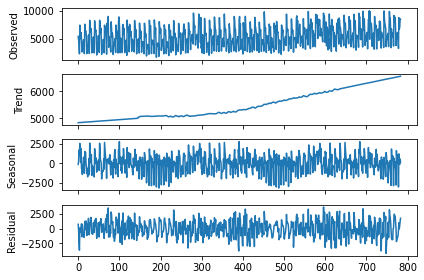

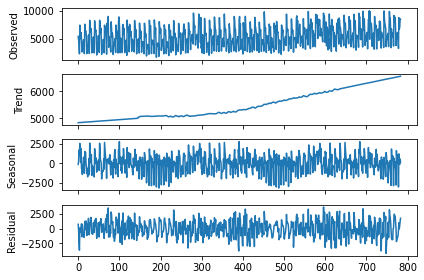

In [131]:
result.plot()

### Save the below as features
- Trend and 
- Seasonality
- Customers

In [132]:
store_dummies['Sales_trend'] = result.trend
store_dummies['Sales_season'] = result.seasonal

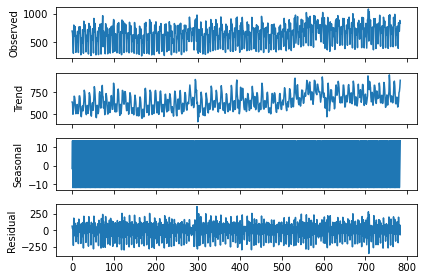

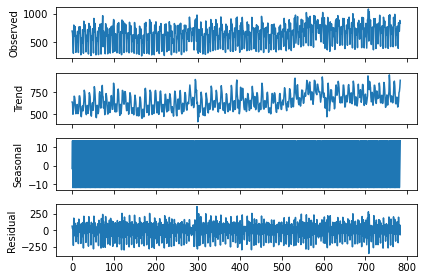

In [133]:
result = udhf_decompose(store_dummies, 'Customers', freq = f_customers)
result.plot()

In [134]:
store_dummies['Customers_trend'] = result.trend
store_dummies['Customers_season'] = result.seasonal

### Check for stationary for the below 
- Sales
- Customers
- Granger Customers and Sales
- Granger Sales ans Customers

In [135]:
udhf_test_stationary(store_dummies, 'Sales')

True

In [136]:
udhf_test_stationary(store_dummies, 'Customers')

True

In [137]:
udhf_granger_test(store_dummies, 'Customers', 'Sales', lags = 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=171.7635, p=0.0000  , df_denom=772, df_num=1
ssr based chi2 test:   chi2=172.4309, p=0.0000  , df=1
likelihood ratio test: chi2=155.6905, p=0.0000  , df=1
parameter F test:         F=171.7635, p=0.0000  , df_denom=772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=167.5666, p=0.0000  , df_denom=769, df_num=2
ssr based chi2 test:   chi2=337.3122, p=0.0000  , df=2
likelihood ratio test: chi2=279.9751, p=0.0000  , df=2
parameter F test:         F=167.5666, p=0.0000  , df_denom=769, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=138.6696, p=0.0000  , df_denom=766, df_num=3
ssr based chi2 test:   chi2=419.8104, p=0.0000  , df=3
likelihood ratio test: chi2=335.3185, p=0.0000  , df=3
parameter F test:         F=138.6696, p=0.0000  , df_denom=766, df_num=3


1.4078965478701753e-35

In [138]:
udhf_granger_test(store_dummies, 'Sales', 'Customers', lags = 1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=107.0836, p=0.0000  , df_denom=772, df_num=1
ssr based chi2 test:   chi2=107.4998, p=0.0000  , df=1
likelihood ratio test: chi2=100.6690, p=0.0000  , df=1
parameter F test:         F=107.0836, p=0.0000  , df_denom=772, df_num=1


1.3671389080044935e-23

- Both granger cause each other !!!

### Prepare train and test datasets
- Generalized the test size to 40 days to best fit the model to most of the regions

In [139]:
test_size = 40 
train_df, test_df = store_dummies.iloc[:-1*test_size], store_dummies.iloc[-1*test_size:]

### Define the below train variable 

- Endogenouse (endog_train) and 
- Exogenous (exog_train)

### Define the below test variables
- Endogenouse (endog_test) and 
- Exogenous (exog_test)


In [140]:
endog_train = train_df[['Sales','Customers']].astype('float32')
exog_train = train_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')


endog_test = test_df[['Sales','Customers']].astype('float32')
exog_test = test_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

# VAR Model Begins Here 

### Define VAR model

In [141]:

model = VAR(endog_train, exog = exog_train)
result = model.select_order(40)
result.summary()
minimum = result.aic
print(minimum)

C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6


### Fit the VAR model

In [142]:
result_fit = model.fit(maxlags = minimum)

In [143]:
predicted_df = pd.DataFrame(result_fit.forecast(y = result_fit.y, steps = test_size, exog_future = exog_test.values), columns = ['Sales', 'Customers'])

C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


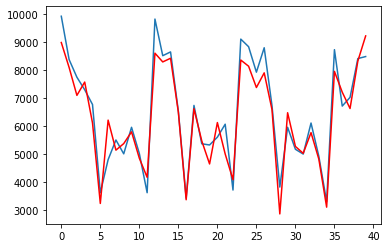

0.02294934204713303
0.07522611606952594


In [144]:
actual=endog_test[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=predicted_df[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)

# plot
plt.plot(actual)
plt.plot(predicted, color='red')
plt.show()

MPE=udhf_calculate_mpe(pred.ActualSales,pred.Sales)
print(MPE)

MAPE=udhf_calculate_mape(pred.ActualSales,pred.Sales)
print(MAPE)

# VAR Model Ends Here 

# VARMAX Model Begins Here

### Define a parametergrid to tune hyperparameters

In [145]:
param_grid = {'p': [1,2,3], 'q':[1,2,3], 'tr': ['n','c','t','ct']}
pg = list(ParameterGrid(param_grid))

In [146]:
res = []
for a,b in enumerate(pg):
    # train a varmax model
    p = b.get('p')
    q = b.get('q')
    tr = b.get('tr')
    print(f"Trying a: {a} p: {p} and q: {q} and tr: {tr}")
    max_model = VARMAX(endog_train, exog = exog_train, order = (p,q), trend = tr) 
    max_result = max_model.fit(disp = False)
    predicted_df = max_result.forecast(steps = test_size, exog = exog_test)
    MPE=np.mean((endog_test.Sales-predicted_df.Sales)/(endog_test.Sales))
    MAPE=np.mean(abs(endog_test.Sales-predicted_df.Sales)/(endog_test.Sales))
    res.append([a,MPE,MAPE])

Trying a: 0 p: 1 and q: 1 and tr: n


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is a

Trying a: 1 p: 1 and q: 1 and tr: c


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 2 p: 1 and q: 1 and tr: t


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 3 p: 1 and q: 1 and tr: ct


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 4 p: 1 and q: 2 and tr: n


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 5 p: 1 and q: 2 and tr: c


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 6 p: 1 and q: 2 and tr: t


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 7 p: 1 and q: 2 and tr: ct


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 8 p: 1 and q: 3 and tr: n


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 9 p: 1 and q: 3 and tr: c


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 10 p: 1 and q: 3 and tr: t


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 11 p: 1 and q: 3 and tr: ct


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 12 p: 2 and q: 1 and tr: n


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 13 p: 2 and q: 1 and tr: c


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 14 p: 2 and q: 1 and tr: t


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 15 p: 2 and q: 1 and tr: ct


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 16 p: 2 and q: 2 and tr: n


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 17 p: 2 and q: 2 and tr: c


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 18 p: 2 and q: 2 and tr: t


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 19 p: 2 and q: 2 and tr: ct


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 20 p: 2 and q: 3 and tr: n


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 21 p: 2 and q: 3 and tr: c


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 22 p: 2 and q: 3 and tr: t


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 23 p: 2 and q: 3 and tr: ct


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 24 p: 3 and q: 1 and tr: n


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 25 p: 3 and q: 1 and tr: c


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 26 p: 3 and q: 1 and tr: t


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 27 p: 3 and q: 1 and tr: ct


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 28 p: 3 and q: 2 and tr: n


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 29 p: 3 and q: 2 and tr: c


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 30 p: 3 and q: 2 and tr: t


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 31 p: 3 and q: 2 and tr: ct


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 32 p: 3 and q: 3 and tr: n


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 33 p: 3 and q: 3 and tr: c


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 34 p: 3 and q: 3 and tr: t


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was 

Trying a: 35 p: 3 and q: 3 and tr: ct


C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [147]:
mape = [abs(res[i][2]) for i in range(len(res))]

In [148]:
pg[np.array(mape).argmin()]

{'p': 3, 'q': 3, 'tr': 'n'}

### Train a VARMAX Model

In [149]:

max_model = VARMAX(endog_train, exog = exog_train, order = (3,3), trend = 'n') 
max_result = max_model.fit(disp = False)

print(max_result.summary())
print(max_result.params)

C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  736
Model:                        VARMAX(3,3)   Log Likelihood               -9961.510
Date:                    Sun, 10 Jan 2021   AIC                          20073.020
Time:                            23:53:49   BIC                          20418.112
Sample:                                 0   HQIC                         20206.109
                                    - 736                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              251.94, 192.87   Jarque-Bera (JB):          3.90, 65.05
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.14, 0.00
Heteroskedasticity (H):         1.37, 1.79   Skew:                       0.18, 0.27
Prob(H) (two-sided):            0.01, 0.00   Kurtosis:                   2.97, 4.35


### Forecast

In [150]:
predicted_df = max_result.forecast(steps = 40, exog = exog_test)

C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


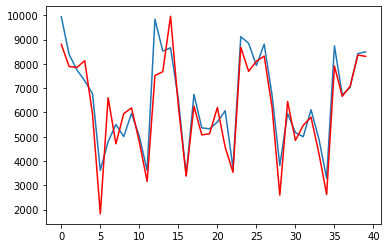

0.04900790052117511
0.10857945217049998


In [151]:
import matplotlib.pyplot as plt

actual=endog_test[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=predicted_df[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)
pred = pred[pred.ActualSales != 0]


# plot
plt.plot(actual)
plt.plot(predicted, color='red')
plt.show()

MPE=udhf_calculate_mpe(pred.ActualSales,pred.Sales)
print(MPE)

MAPE=udhf_calculate_mape(pred.ActualSales,pred.Sales)
print(MAPE)

## Inferences:
- By Observing VAR and VARMAX , VAR slightly better performed than VARMAX

In [152]:
result = udhf_granger_test(store_dummies, 'Customers', 'Sales', lags = 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=171.7635, p=0.0000  , df_denom=772, df_num=1
ssr based chi2 test:   chi2=172.4309, p=0.0000  , df=1
likelihood ratio test: chi2=155.6905, p=0.0000  , df=1
parameter F test:         F=171.7635, p=0.0000  , df_denom=772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=167.5666, p=0.0000  , df_denom=769, df_num=2
ssr based chi2 test:   chi2=337.3122, p=0.0000  , df=2
likelihood ratio test: chi2=279.9751, p=0.0000  , df=2
parameter F test:         F=167.5666, p=0.0000  , df_denom=769, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=138.6696, p=0.0000  , df_denom=766, df_num=3
ssr based chi2 test:   chi2=419.8104, p=0.0000  , df=3
likelihood ratio test: chi2=335.3185, p=0.0000  , df=3
parameter F test:         F=138.6696, p=0.0000  , df_denom=766, df_num=3


In [153]:
result = grangercausalitytests(store_dummies[['Customers', 'Sales']], 2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=107.0836, p=0.0000  , df_denom=772, df_num=1
ssr based chi2 test:   chi2=107.4998, p=0.0000  , df=1
likelihood ratio test: chi2=100.6690, p=0.0000  , df=1
parameter F test:         F=107.0836, p=0.0000  , df_denom=772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=138.6125, p=0.0000  , df_denom=769, df_num=2
ssr based chi2 test:   chi2=279.0276, p=0.0000  , df=2
likelihood ratio test: chi2=238.2781, p=0.0000  , df=2
parameter F test:         F=138.6125, p=0.0000  , df_denom=769, df_num=2


# VARMAX Model Ends Here

# Stationary TimeSeries VARMAX Model Ends Here

# Both Non-Stationary TimeSeries VAR model Starts Here

### Performe the below actions
- Select the Store
- Reverse the order 
- Remove outliers in sales, 99 percentile
- Reset index

In [154]:
store_df = return_storedata(data_df, 30)

In [155]:
store_df = store_df.iloc[::-1]

store_df = udhf_remove_outliers(store_df, 'Sales')

store_df = store_df.reset_index(drop = True)

### Extract Months and Convert to Date Time stamp

In [156]:
store_df['month'] = store_df.Date.apply(lambda str_: datetime.strptime(str_, '%Y-%m-%d').month)

### Create Dummies for 
- Weekdays and 
- Months

In [157]:
store_dummies = return_dummies(store_df, 'DayOfWeek', pref = 'day')
store_dummies = return_dummies(store_dummies, 'month', pref = 'month')

## Check stationary
- Sales Series
- Customers Series

In [158]:
print(f"Does Sales series stationary? {udhf_test_stationary(store_dummies, 'Sales')}")
print(f"Does Customer series stationary? {udhf_test_stationary(store_dummies, 'Customers')}")

Does Sales series stationary? False
Does Customer series stationary? False


In [159]:
store_dummies.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,day_1,day_2,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,30,2013-01-02,5683,943,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30,2013-01-03,6219,987,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,2013-01-04,5035,803,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,2013-01-05,5643,898,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30,2013-01-07,9174,1187,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [160]:
store_dummies = store_dummies.drop(['Store', 'Date', 'Open','StateHoliday'], axis = 1)

## Perform the below actions 
- Decompose the TimeSeries
- Find the frequency with the Lowest Error

In [161]:
f_sales = udhf_find_season(store_dummies, 'Sales')
f_customers = udhf_find_season(store_dummies, 'Customers')

### Save the below as features
- Trend and 
- Seasonality

In [162]:
result = udhf_decompose(store_dummies, 'Sales', freq = f_sales)
store_dummies['Sales_trend'] = result.trend
store_dummies['Sales_season'] = result.seasonal

In [163]:
result = udhf_decompose(store_dummies, 'Customers', freq = f_customers)
store_dummies['Customers_trend'] = result.trend
store_dummies['Customers_season'] = result.seasonal

## Prepare Train and Test Data

In [164]:
lag = 40
train_df, test_df = store_dummies.iloc[:-1*lag], store_dummies.iloc[-1*lag:]

### Define below Train Variables
- Endogenouse(endog_train) and 
- Exogenous (exog_train)

In [165]:
endog_train = train_df[['Sales','Customers']].astype('float32')
exog_train = train_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

In [166]:
endog_diff = endog_train.diff().dropna().reset_index(drop = True)
exog_diff = exog_train.iloc[1:].reset_index(drop = True)

### Define below Test Variables
- Endogenouse (endog_test) and 
- Exogenous (exog_test)

In [167]:
endog_test = test_df[['Sales','Customers']].astype('float32')
exog_test = test_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

### Define VAR Model

In [168]:
model = VAR(endog_diff, exog = exog_diff)
result = model.select_order(f_sales)
result.summary()
minimum = result.aic
minimum

26

### Fit the VAR Model

In [169]:
result_fit = model.fit(maxlags = minimum)

In [170]:
predicted_df = pd.DataFrame(result_fit.forecast(y = result_fit.y, steps = 40, exog_future = exog_test.values), columns = ['Sales', 'Customers'])

C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [171]:
predicted_df['Sales'] = predicted_df['Sales'].cumsum()+train_df['Sales'].values[-1]

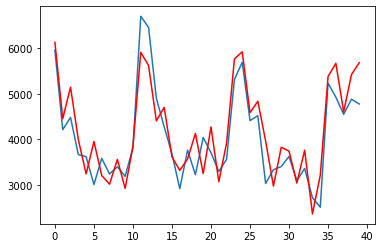

-0.043739153049296764
0.10868338991462105


In [172]:
import matplotlib.pyplot as plt

actual=endog_test[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=predicted_df[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)

# plot section
plt.plot(actual)
plt.plot(predicted, color='red')
plt.show()

MPE=udhf_calculate_mpe(pred.ActualSales,pred.Sales)
print(MPE)

MAPE=udhf_calculate_mape(pred.ActualSales,pred.Sales)
print(MAPE)

In [173]:
# Both Non-Stationary TimeSeries VAR model Ends Here

# One non-stationary time series Starts Here

## Perform Below Actions
- Select the Store
- Reverse the Order
- Remove the outliers in sales, 99 percentile
- Reset the Index
- Extract the Months
- Create dummies for Weekdays and Months

In [174]:
# select store
store_df = return_storedata(data_df, 6)
# reverse order
store_df = store_df.iloc[::-1]
# remove outliers in sales, 99. percentile
store_df = udhf_remove_outliers(store_df, 'Sales')
# reset index
store_df = store_df.reset_index(drop = True)
# extract months
store_df['month'] = store_df.Date.apply(lambda str_: datetime.strptime(str_, '%Y-%m-%d').month)
# create dummies for weekdays and months
store_dummies = return_dummies(store_df, 'DayOfWeek', pref = 'day')
store_dummies = return_dummies(store_dummies, 'month', pref = 'month')

### Check stationary for
- Sales Series
- Customer Series

In [175]:
print(f"Does Sales series stationary? {udhf_test_stationary(store_dummies, 'Sales')}")
print(f"Does Customer series stationary? {udhf_test_stationary(store_dummies, 'Customers')}")

Does Sales series stationary? True
Does Customer series stationary? False


## Perform the below actions
- Drop not useful features
- Decompose the TimeSeries
- Find the Frequency with the Lowest Error
- Save the Trend and Seasonality as Features
- Prepare Train and Test Data

In [176]:

store_dummies = store_dummies.drop(['Store', 'Date', 'Open','StateHoliday'], axis = 1)

f_sales = udhf_find_season(store_dummies, 'Sales')
f_customers = udhf_find_season(store_dummies, 'Customers')

result = udhf_decompose(store_dummies, 'Sales', freq = f_sales)

store_dummies['Sales_trend'] = result.trend
store_dummies['Sales_season'] = result.seasonal

result = udhf_decompose(store_dummies, 'Customers', freq = f_customers)
store_dummies['Customers_trend'] = result.trend
store_dummies['Customers_season'] = result.seasonal

lag = 40
train_df, test_df = store_dummies.iloc[:-1*lag], store_dummies.iloc[-1*lag:]

## Define below train variables and reset index
- Endogenouse (endog_train) and 
- Exogenous(exog_train)

## define endogenouse and exogenous test variables
- Endogenouse(endog_test) and 
- Exogenous(exog_test)

In [177]:
endog_train = train_df[['Sales','Customers']].astype('float32')
exog_train = train_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

endog_diff = endog_train.diff().dropna().reset_index(drop = True)
exog_diff = exog_train.iloc[1:].reset_index(drop = True)


endog_test = test_df[['Sales','Customers']].astype('float32')
exog_test = test_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

## Define VAR model

In [178]:

model = VAR(endog_diff, exog = exog_diff)
result = model.select_order(f_sales)
result.summary()
minimum = result.aic
minimum

28

## Fit the VAR model

In [179]:

result_fit = model.fit(maxlags = minimum)

In [180]:
predicted_df = pd.DataFrame(result_fit.forecast(y = result_fit.y, steps = 40, exog_future = exog_test.values), columns = ['Sales', 'Customers'])

C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [181]:
predicted_df['Sales'] = predicted_df['Sales'].cumsum()+train_df['Sales'].values[-1]

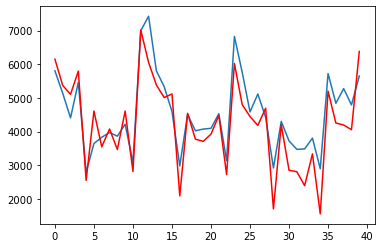

0.0780239471048875
0.12923897493895936


In [182]:
import matplotlib.pyplot as plt

actual=endog_test[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=predicted_df[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)

# plot the graph
plt.plot(actual)
plt.plot(predicted, color='red')
plt.show()

MPE=udhf_calculate_mpe(pred.ActualSales,pred.Sales)
print(MPE)

MAPE=udhf_calculate_mape(pred.ActualSales,pred.Sales)
print(MAPE)

# One non-stationary time series Ends Here

# Fit the pipes and build the Pipeline

### Define udhf_rossmann_prediction Pipeline as Single User Defined Helper Function to re-use for all the stores 
- Select Store
- Reverse Order
- Remove Outliers in sales, 99 Percentile
- Reset Index
- Extract Months
- Create dummies for Weekdays and Months
- Check Stationary
- Drop Not Useful Features
- Decompose the TimeSeries
- Find the frequency with the Lowest Error Sales
- Save the Trend and Seasonality as features
- Find the frequency with the Lowest Error Customers
- Prepare Train Test Data
- Define Endogenouse and Exogenous Train variables
- Difference the TimeSeries if Sales or Customers TimeSeries is not stationary
- Define Endogenouse and Exogenous Test Variables
- Fit the model
- Forecast the model
- If the series is not stationay do difference when necessary
- Benchmark the model
- Plot and save the output as store_{store_id}.png and store_{store_id}.csv

In [183]:
def udhf_rossmann_prediction(data_df, store_id, days = 40, lags_max = 40, plotting = False, max_f = 190):

    # Step 1 : Select the Store
    store_df = return_storedata(data_df, store_id)
    
    # Step 2 : Reverse the Order
    store_df = store_df.iloc[::-1]

    # Step 3 : Remove Outliers in Sales, 99 percentile
    store_df = udhf_remove_outliers(store_df, 'Sales')
    
    # Step 4 : Reset the Index
    store_df = store_df.reset_index(drop = True)

    # Step 5: Extract Months and conver to date timestamp
    store_df['month'] = store_df.Date.apply(lambda str_: datetime.strptime(str_, '%Y-%m-%d').month)

    # Step 6: Create dummies for weekdays and months
    store_dummies = return_dummies(store_df, 'DayOfWeek', pref = 'day')
    store_dummies = return_dummies(store_dummies, 'month', pref = 'month')
    
    # Step 7: Check id the series is Stationary
    sales_stationary = udhf_test_stationary(store_dummies, 'Sales')
    customers_stationary = udhf_test_stationary(store_dummies, 'Customers')
    stationary = sales_stationary and customers_stationary
    
    # Step 8: Drop the Not useful features
    store_dummies = store_dummies.drop(['Store', 'Date', 'Open','StateHoliday'], axis = 1)

    # Step 9: Decompose the TimeSeries
    # Step 10: Find the frequency with the Lowest Error sales
    f_sales = udhf_find_season(store_dummies, 'Sales', fmax = max_f)
    f_customers = udhf_find_season(store_dummies, 'Customers', fmax = max_f)
    result = udhf_decompose(store_dummies, 'Sales', freq = f_sales)
    # Step 11: Save the Trend and Seasonality as features
    store_dummies['Sales_trend'] = result.trend
    store_dummies['Sales_season'] = result.seasonal

    # Step 12: Find the frequency with the Lowest Error customers
    result = udhf_decompose(store_dummies, 'Customers', freq = f_customers)
    # Step 13: Save the Trend and Seasonality as features
    store_dummies['Customers_trend'] = result.trend
    store_dummies['Customers_season'] = result.seasonal

    # Step 14: Prepare Tarin and Test  Data
    train_df, test_df = store_dummies.iloc[:-1*days], store_dummies.iloc[-1*days:]
    
    # Step 15: Define endogenouse and exogenous train variables
    endog_train = train_df[['Sales','Customers']].astype('float32')
    exog_train = train_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

    # Step 16: Difference the timeseries if sales or customers timeseries isn't stationary
    if not stationary:
        endog_train = endog_train.diff().dropna().reset_index(drop = True)
        exog_train = exog_train.iloc[1:].reset_index(drop = True)
        
    # Step 17: Define endogenouse and exogenous test variables
    endog_test = test_df[['Sales','Customers']].astype('float32')
    exog_test = test_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')
    
    # Step 18: Define VAR model
    model = VAR(endog_train, exog = exog_train)
    result = model.select_order(lags_max)
    result.summary()
    minimum = result.aic
    
    # Step 19: Fit the model
    result_fit = model.fit(maxlags = minimum)
    
    # Step 20: Forecast the model
    predicted_df = pd.DataFrame(result_fit.forecast(y = result_fit.y, steps = days, exog_future = exog_test.values), columns = ['Sales', 'Customers'])
    
    # Step 21: Do-difference if necessary
    if not stationary:
        predicted_df['Sales'] = predicted_df['Sales'].cumsum()+train_df['Sales'].values[-1]
    
    # Step 22: Benchmark
    actual=endog_test[["Sales"]]
    actual.columns=['ActualSales']
    actual=actual.reset_index(drop=True)
    predicted=predicted_df[['Sales']]
    predicted=predicted.reset_index(drop=True)
    pred=pd.merge(actual, predicted, right_index=True, left_index=True)

    # Step 23 : Plot and save the output
    fig = plt.figure(figsize = (10,8))
    plt.title(f"{days} business days sales forecasting for Rossmann store ID: {store_id}", fontsize = 16)
    plt.xlabel("days", fontsize = 14)
    plt.ylabel("sales in euro", fontsize = 14)
    plt.plot(actual, label = "Groundtruth")
    plt.plot(predicted, color='red', label = "Forecast")
    plt.legend()
    plt.savefig(f"./store_{store_id}.png")
    if plotting:
        plt.show()
    plt.close(fig)
    
    pred.to_csv(f"./store_{store_id}.csv")
    MPE=udhf_calculate_mpe(pred.ActualSales,pred.Sales)
    

    MAPE=udhf_calculate_mape(pred.ActualSales,pred.Sales)
   
    return [MPE,MAPE,stationary,minimum]

# Rossmann Stores Sales Forecating Pipeline Testing Starts Here

### Test the function for the Store ID 30

C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


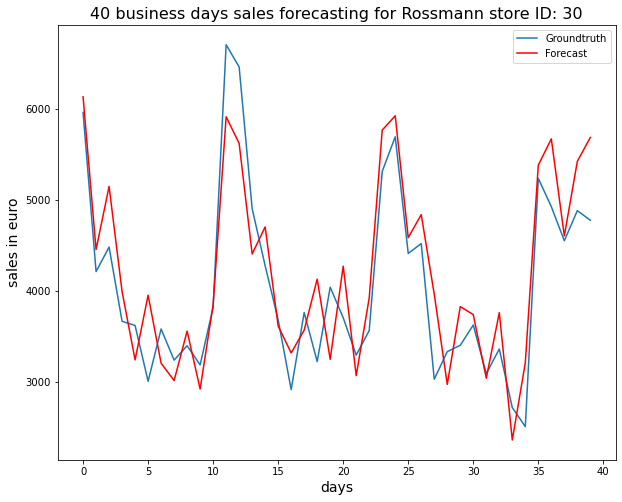

[-0.043739153049296764, 0.10868338991462105, False, 26]

In [184]:
udhf_rossmann_prediction(data_df, 30, days = 40, plotting = True)

### Test the function for the Store ID 8

C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


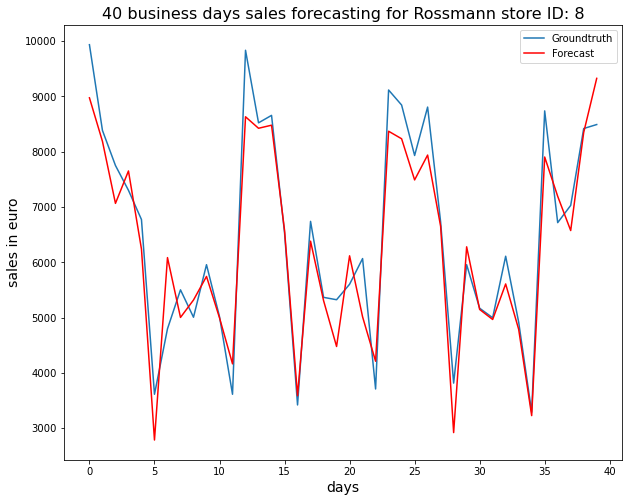

[0.025504822553851884, 0.07737910304100856, True, 8]

In [185]:
udhf_rossmann_prediction(data_df, 8, days = 40, plotting = True)

### Test the function for the Store ID 6

C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


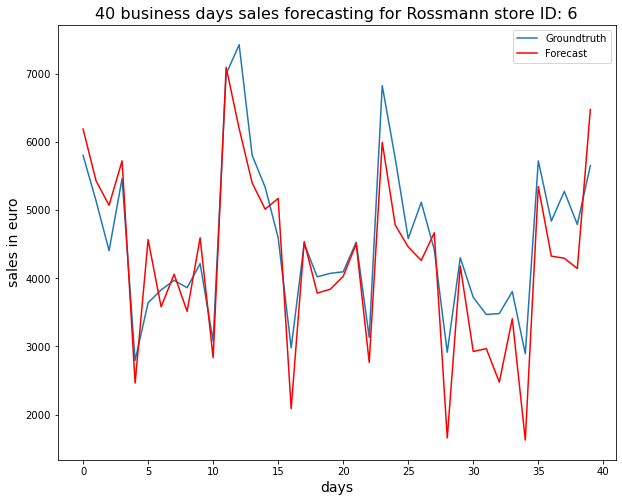

In [186]:
results = udhf_rossmann_prediction(data_df, 6, days = 40, plotting = True)

### Note : This section generates forecasting results in the directory from which this .ipynb file runs

In [187]:
MPEs = []
MAPEs = []
Stationaries = []
AICs = []
for i in range(1,1116):
    results = udhf_rossmann_prediction(data_df, i, days = 40)
    MPEs.append(results[0])
    MAPEs.append(results[1])
    Stationaries.append(results[2])
    AICs.append(results[3])
    print(f"Store ID: {i}\tStationary: {results[2]}\tMPE: {results[0]:.4f}\tMAPE: {results[1]:.4f}\tAIC: {results[3]}")

C:\Users\rajes\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1	Stationary: True	MPE: 0.0249	MAPE: 0.0868	AIC: 15
Store ID: 2	Stationary: True	MPE: -0.0113	MAPE: 0.1012	AIC: 12
Store ID: 3	Stationary: True	MPE: -0.0303	MAPE: 0.0466	AIC: 7
Store ID: 4	Stationary: True	MPE: 0.0557	MAPE: 0.0811	AIC: 14
Store ID: 5	Stationary: True	MPE: -0.0063	MAPE: 0.0628	AIC: 6
Store ID: 6	Stationary: False	MPE: 0.0698	MAPE: 0.1217	AIC: 31
Store ID: 7	Stationary: True	MPE: -0.0232	MAPE: 0.0712	AIC: 6
Store ID: 8	Stationary: True	MPE: 0.0255	MAPE: 0.0774	AIC: 8
Store ID: 9	Stationary: True	MPE: -0.0096	MAPE: 0.0674	AIC: 6
Store ID: 10	Stationary: True	MPE: -0.0153	MAPE: 0.0854	AIC: 12
Store ID: 11	Stationary: True	MPE: 0.0302	MAPE: 0.1055	AIC: 13
Store ID: 12	Stationary: True	MPE: 0.0484	MAPE: 0.0845	AIC: 8
Store ID: 13	Stationary: True	MPE: -0.0365	MAPE: 0.1169	AIC: 3
Store ID: 14	Stationary: True	MPE: 0.0228	MAPE: 0.0600	AIC: 12
Store ID: 15	Stationary: True	MPE: 0.0176	MAPE: 0.0931	AIC: 7
Store ID: 16	Stationary: True	MPE: -0.0270	MAPE: 0.0772	AIC: 6
S

In [188]:
print(f"Average MPE: {np.mean(MPEs):.4f}\nAverage MAPE: {np.mean(MAPEs):.4f}")

Average MPE: -0.0076
Average MAPE: 0.0906


# Rossmann Stores Sales Forecating Pipeline Testing Ends Here

### ============================================================================

# <font color = Grey>That Concludes:</font>
- ## <font color = blue> Time Series Forecasting </font> <font color = Grey>.  Rossmann Stores Sales Forecating Pipeline Performing Best </font>

- ## <font color = Grey>Great Learning of PGD with</font> <font color = blue> UpGrad and IIITB in the grounds of ML and AI </font>

### ============================================================================
# <font color = Grey>New beginning of MSC :</font> <font color = blue> UpGrad and LJMU</font>
### ============================================================================

# <font color = Grey>Voyage Continues in the</font> <font color = blue>Learning of Excellence ...</font>


## ==============================================================
# Learning Experienced By  : <font color = blue>Rajesh Suguru</font>
## ==============================================================